In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [145]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Read the data from Excel file

df = pd.read_excel('IA_House_Price_Original_Data.xlsx')


In [ ]:
#Convert numeric-like columns to numeric type

#Identify columns that can be converted to numeric
numeric_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 80']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
#Handle categorical columns

#Identify categorical columns 
categorical_columns = df.select_dtypes(include=['object']).columns

#Fill NaN values in categorical columns
for col in categorical_columns:
    mode_value = df[col].mode()
    if not mode_value.empty:
        df[col] = df[col].fillna(mode_value.iloc[0])
    else:
        #If mode is empty, fill with a placeholder value
        df[col] = df[col].fillna('Unknown')

#Verify the changes
print(df[categorical_columns].isnull().sum())

#Apply one-hot encoding to categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#Handle missing values in numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[nuumeric_columns].median())


In [ ]:
for col in categorical_columns:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))
    print("\n")

In [ ]:
#Prepare features and target variable
X = df.drop(['Unnamed: 80', 'Unnamed: 81'], axis=1) #Features
y = df['Unnamed: 80'] #Target variable


In [135]:

#Split data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42)

print(X_train.dtypes)
print(X_train.head())


Unnamed: 0                   float64
Unnamed: 1                   float64
Unnamed: 3                   float64
Unnamed: 4                   float64
Unnamed: 75                  float64
                              ...   
Unnamed: 79_Alloca              bool
Unnamed: 79_Family              bool
Unnamed: 79_Normal              bool
Unnamed: 79_Partial             bool
Unnamed: 79_SaleCondition       bool
Length: 9090, dtype: object
      Unnamed: 0  Unnamed: 1  Unnamed: 3  Unnamed: 4  Unnamed: 75  \
1727      1729.0        60.0        68.0     10274.0          0.0   
2855      2864.0        60.0        90.0     11060.0          0.0   
1923      1925.0        60.0        75.0      9157.0          0.0   
2672      2681.0        60.0        68.0      9233.0          0.0   
2803      2812.0        80.0        68.0      7176.0          0.0   

      Unnamed: 76  Unnamed: 2_FV  Unnamed: 2_MSZoning  Unnamed: 2_RH  \
1727          7.0          False                False          False   
2855  

In [137]:

#Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [153]:
#Linear Regression

#Train the Linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

#Predict on validation set
y_pred = linear_model.predict(X_val_scaled)

#Calculate R-squared and MSE
r2_val = r2_score(y_val, y_pred)
mse_val = mean_squared_error(y_val, y_pred)

print(f"Validation R-squared: {r2_val:.2f}")
print(f"Validation MSE: {mse_val:.2f}")


Validation R-squared: 0.72
Validation MSE: 1899069022.90


In [117]:
#Ridge Regression

ridge_models = {}
lambda_ridge = [0.10, 0.30, 0.60]

#Train Ridge models for each lambda
for l in lambda_ridge:
    ridge = Ridge(alpha=l)
    ridge.fit(X_train_scaled, y_train)
    ridge_models[l] = ridge

#Evaluate Ridge models on validation set
ridge_val_mse = {l: mean_squared_error(y_val, model.predict(X_val_scaled)) for l, model in ridge_models.items()}

In [119]:
#Lasso Regression

lasso_models = {}
lambda_lasso = [0.02, 0.06, 0.10]

#Train Lasso models for each lambda
for l in lambda_lasso:
    lasso = Lasso(alpha=1, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_models[l] = lasso

#Evaluate Lasso models on validation set
lasso_val_mse = {l: mean_squared_error(y_val, model.predict(X_val_scaled)) for l, model in lasso_models.items()}

In [123]:
#Select the best models based on validation performance
best_lambda_ridge = min(ridge_val_mse, key=ridge_val_mse.get)
best_lambda_lasso = min(lasso_val_mse, key=lasso_val_mse.get)

print(f"Best Ridge lambda {best_lambda_ridge}, MSE: {ridge_val_mse[best_lambda_ridge]}")
print(f"Best Lasso lambda {best_lambda_lasso}, MSE: {lasso_val_mse[best_lambda_lasso]}")


Best Ridge lambda 0.6, MSE: 1887010127.5116017
Best Lasso lambda 0.02, MSE: 1095880019.3728235


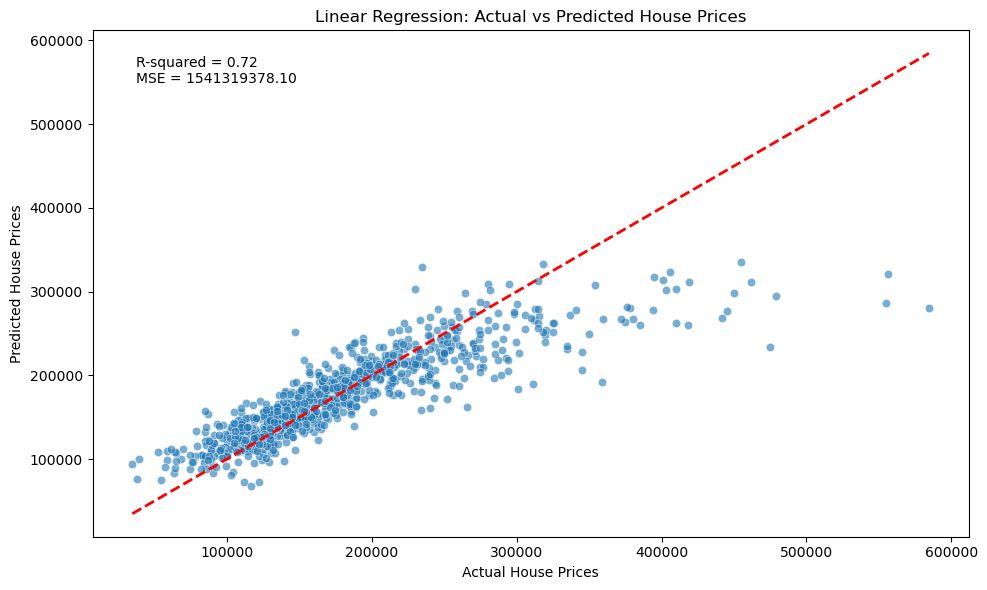

In [96]:

#Get predictions for the test set
y_pred = linear_model.predict(X_test_scaled)

#Create the scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

#Add the ideal prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

#Customize the plot
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Linear Regression: Actual vs Predicted House Prices')

#Add text for R-squared and MSE
r2 = linear_model.score(X_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred)
plt.text(0.05, 0.95, f'R-squared = {r2:.2f}\nMSE = {mse:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')

#Show the plot
plt.tight_layout()
plt.show()

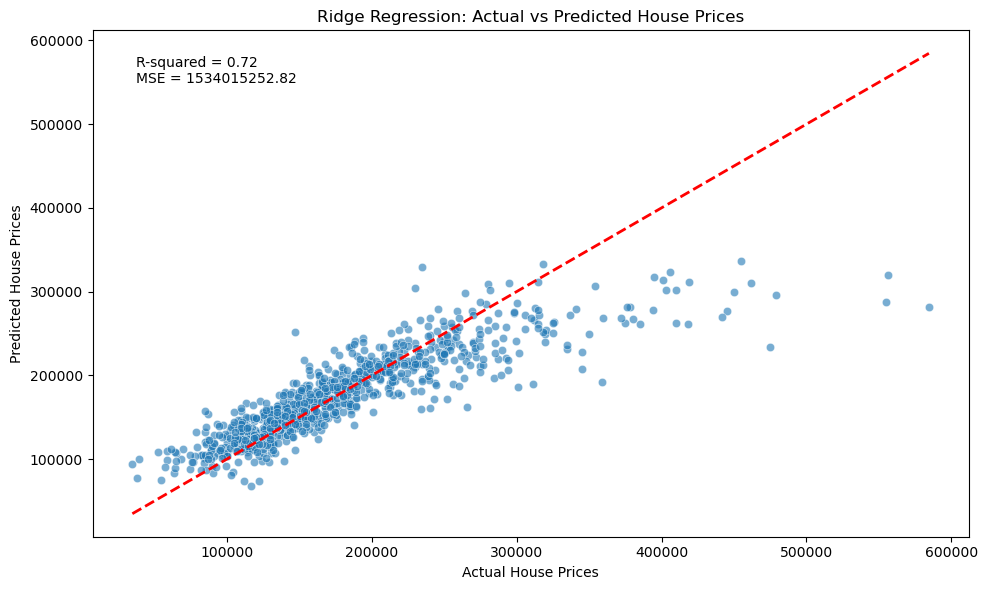

In [155]:
#Choose the best lambda based on validation performance
# best_lambda_ridge = 0.6 

#Get the best model
ridge_model = ridge_models[best_lambda_ridge]

#Get predictions for the test set
y_pred_ridge = ridge_model.predict(X_test_scaled)

#Create the scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.6)

#Add the ideal prediction line
min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

#Customize the plot
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Ridge Regression: Actual vs Predicted House Prices')

#Add text for R-squared and MSE
r2_ridge = ridge_model.score(X_test_scaled, y_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
plt.text(0.05, 0.95, f'R-squared = {r2_ridge:.2f}\nMSE = {mse_ridge:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')

#Show the plot
plt.tight_layout()
plt.show()



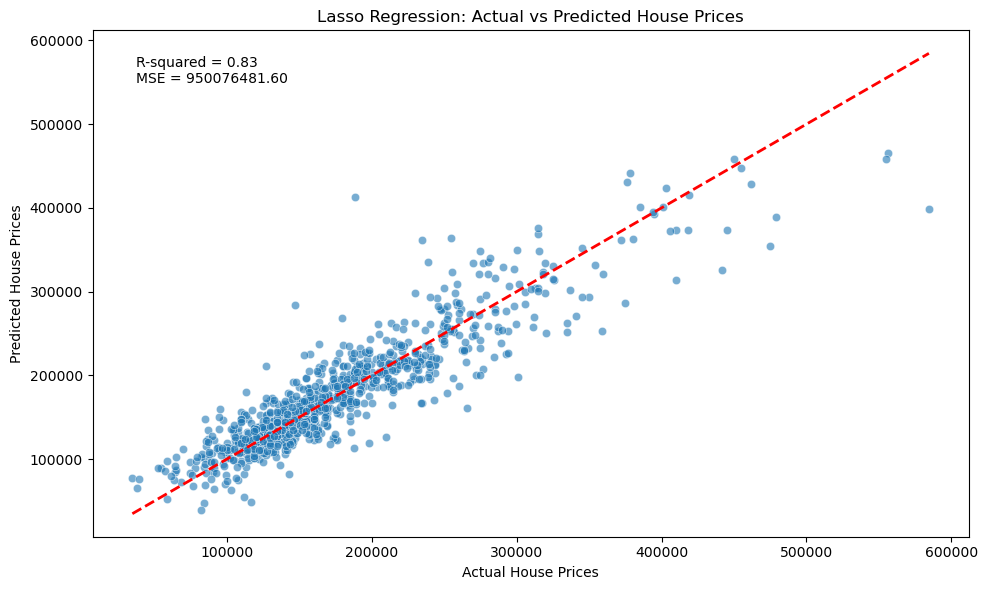

In [129]:
#Choose the best lambda based on validation performance
# best_lambda_lasso = 0.02 

#Get the best model
lasso_model = lasso_models[best_lambda_lasso]

#Get predictions for the test set
y_pred_lasso = lasso_model.predict(X_test_scaled)

#Create a scatter plot for Lasso
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.6)

min_val = min(y_test.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_lasso.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Lasso Regression: Actual vs Predicted House Prices')

#Add text for R-squared and MSE
r2_lasso = lasso_model.score(X_test_scaled, y_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
plt.text(0.05, 0.95, f'R-squared = {r2_lasso:.2f}\nMSE = {mse_lasso:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top')


plt.tight_layout()
plt.show()